#### imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt

### strcuture of different datasets

#### df_channels_en.tsv

CSV file, having the following structure:
| **category_cc** | **join_date** | **channel**              | **name_cc**             | **subscribers_cc** | **videos_cc** | **subsriber_rank_sb** | **weights** |
|-----------------|---------------|--------------------------|-------------------------|--------------------|---------------|-----------------------|-------------|
| News & Politics | 2013-03-11    | UCcRgZlgsk5m-aDQa_d6BTkQ | NorthWestLibertyNews... | 16700              | 845           | 639043.0              | 10.0035     |
| Gaming          |    2012-01-15 | UCnnXR0VIJVpeL1wEr-bBaRw | Felix Guaman            | 112000             | 703           | 137318.0              | 5.4915      |

With:
- `category_cc`: most frequent category of the channel. One of: ['Gaming', 'Education', 'Entertainment', 'Howto & Style', 'Sports', 'Music', 'Film and Animation', 'Comedy', 'Nonprofits & Activism', 'People & Blogs', 'News & Politics', 'Science & Technology', 'Pets & Animals', 'Autos & Vehicles', 'Travel & Events', nan]
- `join_date`: join date of the channel.
- `channel`: unique channel id.
- `name_cc`: name of the channel.
- `subscribers_cc`: number of subscribers.
- `videos_cc`: number of videos.
- `subscriber_rank_sb`: rank in terms of number of subscribers.
- `weights`: weights cal



#### yt_metadata_helper.feather   (yt_metadata_helper.feather.csv, filtered_yt_metadata_helper.feather.csv)
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>categories</th>
      <th>channel_id</th>
      <th>dislike_count</th>
      <th>display_id</th>
      <th>duration</th>
      <th>like_count</th>
      <th>upload_date</th>
      <th>view_count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Film &amp; Animation</td>
      <td>UCy6sWF4taso5GtrfDGhwpBA</td>
      <td>0.0</td>
      <td>EXOviJ_EJDo</td>
      <td>68</td>
      <td>0.0</td>
      <td>2011-12-07</td>
      <td>76.0</td>
    </tr>
    <tr>
      <td>Gaming</td>
      <td>UCEPYwwuGhgA9wfO2It11OXw</td>
      <td>0.0</td>
      <td>xSKA6VX7Tdo</td>
      <td>125</td>
      <td>6.0</td>
      <td>2016-10-04</td>
      <td>198.0</td>
    </tr>
    <tr>
      <td>News &amp; Politics</td>
      <td>UCojNA7ZvnmGuIvYnm44wl3Q</td>
      <td>NaN</td>
      <td>FsucWMijKA4</td>
      <td>130</td>
      <td>NaN</td>
      <td>2010-11-18</td>
      <td>106.0</td>
    </tr>
  </tbody>
</table>
</div>

With (values were crawled from YouTube between 2019-10-29 and 2019-11-23):
- `categories`: category (self-defined when they upload a video to YouTube)
- `channel_id`: unique channel id
- `dislike_count`: dislikes of the video
- `display_id`: unique video id
- `duration`: duration of the video
- `like_count`:likes of the video.
- `upload_date`: upload date
- `view_count`: views of the video.


#### yt_metadata.jsonl
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>categories</th>
      <th>channel_id</th>
      <th>crawl_date</th>
      <th>description</th>
      <th>dislike_count</th>
      <th>display_id</th>
      <th>duration</th>
      <th>like_count</th>
      <th>tags</th>
      <th>title</th>
      <th>upload_date</th>
      <th>view_count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Film &amp; Animation</td>
      <td>UCy6sWF4taso5GtrfDGhwpBA</td>
      <td>2019-10-29</td>
      <td>description</td>
      <td>0.0</td>
      <td>EXOviJ_EJDo</td>
      <td>68</td>
      <td>0.0</td>
      <td>tags</td>
      <td>title</td>
      <td>2011-12-07</td>
      <td>76.0</td>
    </tr>
    <tr>
      <td>Gaming</td>
      <td>UCEPYwwuGhgA9wfO2It11OXw</td>
      <td>2019-10-29</td>
      <td>description</td>
      <td>0.0</td>
      <td>xSKA6VX7Tdo</td>
      <td>125</td>
      <td>6.0</td>
      <td>tags</td>
      <td>title</td>
      <td>2016-10-04</td>
      <td>198.0</td>
    </tr>
    <tr>
      <td>News &amp; Politics</td>
      <td>UCojNA7ZvnmGuIvYnm44wl3Q</td>
      <td>2019-10-29</td>
      <td>description</td>
      <td>NaN</td>
      <td>FsucWMijKA4</td>
      <td>130</td>
      <td>NaN</td>
      <td>tags</td>
      <td>title</td>
      <td>2010-11-18</td>
      <td>106.0</td>
    </tr>
  </tbody>
</table>
</div>

With (values were crawled from YouTube between 2019-10-29 and 2019-11-23):
- `categories`: category (self-defined when they upload a video to YouTube)
- `channel_id`: unique channel id
- `dislike_count`: dislikes of the video
- `display_id`: unique video id
- `duration`: duration of the video
- `like_count`:likes of the video.
- `upload_date`: upload date
- `view_count`: views of the video.

#### df_timeseries_en.tsv

| **channel**              | **category**       | **datetime** | **views**   | **delta_views** | **subs** | **delta_subs** | **videos** | **delta_videos** | **activity** |
|--------------------------|--------------------|--------------|-------------|-----------------|----------|----------------|------------|------------------|--------------|
| UCBJuEqXfXTdcPSbGO9qqn1g | Film and Animation | 2017-07-03 | 202495  |           0 |  650 |   0        |      5 |            0 |        3 |
| UCBJuEqXfXTdcPSbGO9qqn1g | Film and Animation | 2017-07-10 | 394086  |      191591 | 1046 | 396        |      6 |            1 |        1 |

With:
- `channel`: channel id.
- `category`: category of the channel as assigned by `socialblade.com` according to the last 10 videos at time of crawl.
- `datetime`: Week related to the data point.
- `views`: Total number of views the channel had this week.
- `delta_views`: Delta views obtained this week.
- `subs`: Total number of subscribers the channel had this week.
- `delta_subs`: Delta subscribers obtained this week.
- `videos`: Total number of videos the channel had this week.
- `delta_videos`: Delta videos obtained this week.
- `activity`: Number of videos published in the last 15 days.


#### youtube_comments.tsv

| **author** | **video_id**      |  **likes** |  **replies** |
|------|--------------|-------|---------|
| 1      | Gkb1QMHrGvA   |  2     |  0       |
| 1      | CNtp0xqoods   |  0     |  0       |
| 1      | 249EEzQmVmQ   |  1     |  0       |

With (data obtained at crawl time between 2019-09-12 and 2019-09-17):
- `author`: anonymized author id (unique)
- `video_id`: unique video id of the video the comment was written
- `likes`: likes for the comment
- `replies`: replies for the comment

In [22]:
# df_ch_f = pd.read_csv("./Youniverse/df_channels_en.tsv", sep="\t")

pl_df_f = pl.read_csv("./Youniverse/df_channels_en.tsv", separator="\t")

filtered_df_ch = pl_df_f.filter(pl.col("category_cc") == "News & Politics")
pl_df_f.sample(5)

category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
str,str,str,str,i64,i64,f64,f64
"""Film and Animation""","""2014-11-17""","""UCZbTuDplLcBb4bTHa_-5_UA""","""Kids TV India Hindi ...""",3598994,769,2127.0,2.13
"""Autos & Vehicles""","""2008-12-19""","""UCc21o3x3-P_ehovL2Vl2EuA""","""Polaris Snowmobiles""",16500,548,663308.0,9.6105
"""Entertainment""","""2017-03-25""","""UCRgm9gEYqdoFazXmciCKk4w""","""Shivraj Music Marath...""",369000,290,42624.0,3.3235
"""News & Politics""","""2013-03-16""","""UCbdfEJ4_kDmKeZ_CbWIM-Dw""","""Elite Investor TV""",10200,329,934111.0,23.727
"""People & Blogs""","""2010-08-16""","""UCMZj8zlrcPInWyR479Acnsw""","""Young Shun""",10600,190,923466.0,17.0865


In [ ]:
# df_vd_f = pd.read_feather("../Youniverse/yt_metadata_helper.feather")

# df_vd_f.sample(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
16583269,Film & Animation,UCy6sWF4taso5GtrfDGhwpBA,0.0,EXOviJ_EJDo,68,0.0,2011-12-07,76.0
51429663,Gaming,UCEPYwwuGhgA9wfO2It11OXw,0.0,xSKA6VX7Tdo,125,6.0,2016-10-04,198.0
4222786,News & Politics,UCojNA7ZvnmGuIvYnm44wl3Q,NaN,FsucWMijKA4,130,NaN,2010-11-18,106.0
61632041,Music,UC6SemiBqCDvv2XsWVqD8mgg,0.0,3PGYujlHr38,290,0.0,2018-06-09,0.0
31333325,Sports,UCTtkVP_v56wU8zXpVBpdaZQ,0.0,BKvxa7AbuMI,263,2.0,2016-08-26,1201.0


In [ ]:
# save to csv
# df_vd_f.to_csv("../Youniverse/yt_metadata_helper.feather.csv", sep="\t")

In [5]:
filtered_df_ch.filter(pl.col("channel").is_in(filtered_df_ch["channel"]))

category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
str,str,str,str,i64,i64,f64,f64
"""News & Politics""","""2006-08-26""","""UCttspZesZIDEwwpVIgoZtWQ""","""IndiaTV""",15177282,139814,199.0,2.087
"""News & Politics""","""2012-06-01""","""UCRWFSbif-RFENbBrSiez1DA""","""ABP NEWS""",16274836,129027,207.0,2.087
"""News & Politics""","""2017-03-03""","""UCmphdqZNmqL72WJ2uyiNw5w""","""ABP NEWS HINDI""",10800000,51298,340.0,2.087
"""News & Politics""","""2015-03-23""","""UCx8Z14PpntdaxCt2hakbQLQ""","""The Lallantop""",9120000,9423,438.0,2.087
"""News & Politics""","""2007-06-19""","""UCIvaYmXn910QMdemBG3v1pQ""","""Zee News""",9280000,102648,549.0,2.087
…,…,…,…,…,…,…,…
"""News & Politics""","""2010-08-07""","""UC5rxiCGcNunIi5zI1hMYLMg""","""Salman Akhtar""",10400,40,962468.0,53.1435
"""News & Politics""","""2013-02-01""","""UCLSEJQ8TWtlEkaytaa4Y7lw""","""WingsOfChrist""",10420,61,962547.0,53.1435
"""News & Politics""","""2012-10-19""","""UCnkG_c5cyemVVsgCDoHiXew""","""The American Mirror""",10500,329,963417.0,53.1435


In [ ]:
# load yt metadata in chunks and filter for videos contained in filtered_df_ch
# df.filter(pl.col("categories") == "News & Politics") to filter for categories of videos instead
reader = pl.read_csv_batched(
    "../Youniverse/yt_metadata_helper.feather.csv",
    separator="\t",
    batch_size=5000
)


batches = reader.next_batches(5)  
i = 0
while batches:
    for df in batches:
        if i == 0:
            df.filter(pl.col("channel_id").is_in(filtered_df_ch["channel"])).write_csv("../Youniverse/filtered_yt_metadata_helper.feather.csv", include_header=True)
        else:
            with open("../Youniverse/filtered_yt_metadata_helper.feather.csv", "a") as fh:
                fh.write(df.filter(pl.col("channel_id").is_in(filtered_df_ch["channel"])).write_csv(file=None, include_header=False))
        i = i+1
        print(f"batch {i}\r", end='')
    batches = reader.next_batches(5)

In [4]:
filtered_df_metadata_feather = pl.read_csv("../Youniverse/filtered_yt_metadata_helper.feather.csv")
filtered_df_metadata_feather.sample(5)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
i64,str,str,f64,str,i64,f64,str,f64
61009636,"""News & Politics""","""UCubZ7j3sba8uguy8Yq6xi_A""",3.0,"""kWhdrNWM72M""",184,9.0,"""2019-08-30""",1453.0
68736078,"""News & Politics""","""UC0bBYj4NEC416pOu4Krjmpg""",0.0,"""Z3ABMTXxfzY""",663,1.0,"""2019-08-12""",20.0
535713,"""News & Politics""","""UCruQg25yVBppUWjza8AlyZA""",0.0,"""fQnbyGVkZT4""",230,2.0,"""2017-04-03""",125.0
38316830,"""News & Politics""","""UCO0akufu9MOzyz3nvGIXAAw""",1.0,"""Eld1j4HByp0""",152,2.0,"""2014-06-12""",691.0
38312788,"""News & Politics""","""UCO0akufu9MOzyz3nvGIXAAw""",3.0,"""rteI-V2kkf0""",351,2.0,"""2019-08-09""",142.0


In [5]:
len(filtered_df_metadata_feather)

9503610

In [6]:
list(filtered_df_metadata_feather["categories"].unique())

['Entertainment',
 'News & Politics',
 'Education',
 'Gaming',
 'Comedy',
 'Nonprofits & Activism',
 'Music',
 None,
 'Travel & Events',
 'Pets & Animals',
 'Sports',
 'People & Blogs',
 'Autos & Vehicles',
 'Science & Technology',
 'Howto & Style',
 'Film & Animation']

In [7]:
filtered_df_metadata_feather["categories"].value_counts().sort(by="count", descending=True)

categories,count
str,u32
"""News & Politics""",8261387
"""Entertainment""",398379
"""People & Blogs""",389905
"""Sports""",116509
"""Education""",72252
…,…
"""Comedy""",21957
"""Pets & Animals""",12286
"""Autos & Vehicles""",10680


In [10]:
chunks = pd.read_json("../Youniverse/yt_metadata_en.jsonl", lines=True, chunksize = 500)
for i, c in enumerate(chunks):
    c = c[c["channel_id"].isin(filtered_df_ch["channel"])]
    if i == 0:
        print(c)
        c.to_csv("../Youniverse/filtered_yt_metadata.csv", header=True, index=False)
    else: 
        with open("../Youniverse/filtered_yt_metadata.csv", "a") as fh:
            fh.write(c.to_csv(path_or_buf=None, header=False, index=False))
    print(f"batch {i} / 145390 \r", end="")

Empty DataFrame
Columns: [categories, channel_id, crawl_date, description, dislike_count, display_id, duration, like_count, tags, title, upload_date, view_count]
Index: []


In [9]:
# load yt metadata in chunks and filter for videos contained in filtered_df_ch
# df.filter(pl.col("categories") == "News & Politics") to filter for categories of videos instead
batch_size = 10000
reader = pl.read_csv_batched(
    "../Youniverse/youtube_comments.tsv",
    separator="\t",
    batch_size= batch_size
)

total_batches = 8600000000/batch_size

batches = reader.next_batches(5)  
i = 0
while batches:
    for df in batches:
        if i == 0:
            # df.filter(pl.col("video_id").is_in(filtered_df_metadata_feather["display_id"])).write_csv("../Youniverse/filtered_youtube_comments.tsv", include_header=True)
            df.filter(pl.col("video_id") == "fXN0ABkfZ7M").write_csv("../Youniverse/filtered_youtube_comments.tsv", include_header=True)
        else:
            with open("../Youniverse/filtered_youtube_comments.tsv", "a") as fh:
                fh.write(df.filter(pl.col("video_id") == "fXN0ABkfZ7M").write_csv(file=None, include_header=False))
        i = i+1
        print(f"batch {i} / {total_batches} \r", end='')
    batches = reader.next_batches(5)

KeyboardInterrupt: 

In [ ]:
# load yt metadata in chunks and filter for videos contained in filtered_df_ch
reader = pl.read_csv_batched(
    "../Youniverse/num_comments_authors.tsv",
    separator="\t",
    batch_size=5000
)  
batches = reader.next_batches(5)  
for df in batches:  
    print(df)

shape: (4_600, 4)
┌────────┬─────────────┬───────┬─────────┐
│ author ┆ video_id    ┆ likes ┆ replies │
│ ---    ┆ ---         ┆ ---   ┆ ---     │
│ i64    ┆ str         ┆ i64   ┆ i64     │
╞════════╪═════════════╪═══════╪═════════╡
│ 1      ┆ Gkb1QMHrGvA ┆ 2     ┆ 0       │
│ 1      ┆ CNtp0xqoods ┆ 0     ┆ 0       │
│ 1      ┆ 249EEzQmVmQ ┆ 1     ┆ 0       │
│ 1      ┆ _U443T2K_Bs ┆ 0     ┆ 0       │
│ 1      ┆ rJbjhm0weYc ┆ 0     ┆ 0       │
│ …      ┆ …           ┆ …     ┆ …       │
│ 314    ┆ cvrCYT7Oyt4 ┆ 0     ┆ 0       │
│ 314    ┆ B90EzQj2wOQ ┆ 0     ┆ 0       │
│ 314    ┆ BkHuP2ZEtAY ┆ 0     ┆ 0       │
│ 314    ┆ 9ndXWa3j91I ┆ 0     ┆ 0       │
│ 314    ┆ 9qfNbzqZlBk ┆ 0     ┆ 0       │
└────────┴─────────────┴───────┴─────────┘
shape: (4_490, 4)
┌────────┬─────────────┬───────┬─────────┐
│ author ┆ video_id    ┆ likes ┆ replies │
│ ---    ┆ ---         ┆ ---   ┆ ---     │
│ i64    ┆ str         ┆ i64   ┆ i64     │
╞════════╪═════════════╪═══════╪═════════╡
│ 314    ┆ LGmLi4R

In [18]:
list(pl_df_f["category_cc"].unique())

['People & Blogs',
 'Pets & Animals',
 'Music',
 'Travel & Events',
 'Science & Technology',
 'Gaming',
 'News & Politics',
 'Entertainment',
 'Autos & Vehicles',
 None,
 'Film and Animation',
 'Howto & Style',
 'Education',
 'Sports',
 'Comedy',
 'Nonprofits & Activism']

## Filtering of activity

In [2]:
df_timeseries = pl.read_csv("../Youniverse/df_timeseries_en.tsv", separator="\t")
df_timeseries.sample(5)

channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
str,str,str,f64,f64,f64,f64,i64,i64,i64
"""UCJww8QPm8oNnyVXpkCyBItQ""","""Sports""","""2019-05-27 01:00:00""",1.5613e7,1.3935e6,40853.898148,3323.054398,35,4,7
"""UCa_BC8f_XoUTGujN8NjsMng""","""Music""","""2019-04-29 00:00:00""",2.1831e7,125544.75,108475.0,385.0,597,3,6
"""UCoykA7vQjXcZa7zo7GorLlg""","""People & Blogs""","""2017-07-03 00:00:00""",4.727559e6,3583.625,28097.0,33.375,88,0,0
"""UC0n7hqQFFEZnwxrcVh09uVA""",null,"""2017-09-25 00:00:00""",3.3235e7,256583.25,217129.5,1305.5,43,0,0
"""UC-tdPPVqdLB77oimoSOC4tg""","""People & Blogs""","""2019-04-01 00:00:00""",1.2675e7,20641.539812,201634.424084,102.356375,66,0,0


In [4]:
df_timeseries.filter(pl.col("channel").is_in(filtered_df_ch["channel"])).write_csv("../Youniverse/filtered_df_timeseries_en.tsv", include_header=True, separator="\t")

In [4]:
filtered_df_timeseries = pl.read_csv("./Youniverse/filtered_df_timeseries_en.tsv", separator="\t")
filtered_df_timeseries.sample(5)

channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
str,str,str,f64,f64,f64,f64,i64,i64,i64
"""UCcK_ytDOdC6QXqD5YxuoYUw""","""News & Politics""","""2019-04-29 01:00:00""",1.8584e7,570696.583333,91951.802083,1394.75,879,0,0
"""UCvOQwFjV0T8UsTDVGUOM7Gg""","""News & Politics""","""2017-07-10 01:00:00""",2.2825e6,11948.86713,7767.270833,65.608796,1234,6,13
"""UCjckQxT9ByiA3qEBjjrnGJg""","""News & Politics""","""2016-09-05 00:00:00""",2.2103e6,16986.625,2384.875,24.125,260,1,4
"""UCGlvY4d9cwinzAb0ZLHRlMw""","""News & Politics""","""2019-02-03 23:00:00""",6.7261e6,6130.630556,51085.033333,0.0,347,4,7
"""UCgxFR_TQOD8Uvi9rE3rM1cQ""","""News & Politics""","""2017-07-03 00:00:00""",4684557.5,58964.375,28218.0,149.0,95,1,1


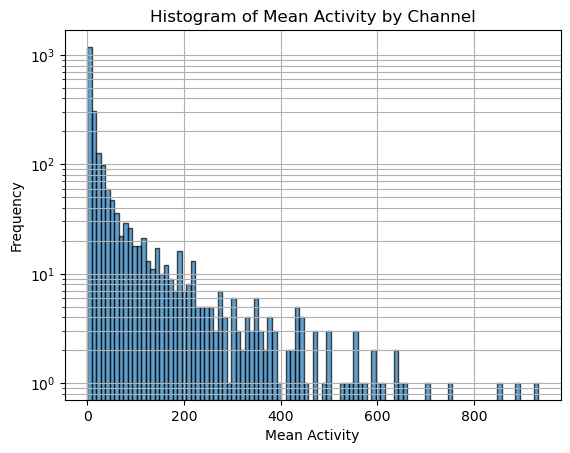

In [12]:
grouped_df = filtered_df_timeseries.group_by('channel').agg(pl.col('activity').mean().alias('mean_activity'))

# Extract the mean activity values into a list
mean_activities = grouped_df['mean_activity'].to_list()

# Plot histogram of the mean activity values
plt.hist(mean_activities, bins=100, edgecolor="black", alpha=0.7)
plt.xlabel('Mean Activity')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Activity by Channel')
# plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both")
plt.show()


In [19]:
# 56 == 4 videos per day
len(grouped_df.filter(pl.col("mean_activity")>56))

407

In [41]:
high_activity_channels = filtered_df_ch.filter(pl.col("channel").is_in(grouped_df.filter(pl.col("mean_activity")>56)["channel"]))
# merge high_activity_channels with grouped_df on the channel column
high_activity_channels = high_activity_channels.join(grouped_df, on="channel", how="inner")
high_activity_channels.sort(by="mean_activity", descending=True).head(10)

category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,mean_activity
str,str,str,str,i64,i64,f64,f64,f64
"""News & Politics""","""2013-02-15""","""UCKwucPzHZ7zCUIf7If-Wo1g""","""DD News""",2020000,95333,6107.0,2.4695,932.258065
"""News & Politics""","""2018-05-29""","""UCrp_UI8XtuYfpiqluWLD7Lw""","""CNBC Television""",265000,27787,51809.0,3.4695,886.646154
"""News & Politics""","""2012-02-29""","""UC8yH-uI81UUtEMDsowQyx1g""","""SABC Digital News""",650000,115295,24075.0,2.92,857.458065
"""News & Politics""","""2014-04-17""","""UCKQECjul8nw1KW_JzfBTP1A""","""KPRC 2 Click2Houston...""",42700,40313,237317.0,4.8895,748.161616
"""News & Politics""","""2011-12-15""","""UCPXTXMecYqnRKNdqdVOGSFg""","""TV9 Telugu Live""",3980000,60864,2014.0,2.1045,701.548387
"""News & Politics""","""2015-05-23""","""UCYPvAwZP8pZhSMW8qs7cVCw""","""India Today""",2250000,74453,4479.0,2.363,653.403846
"""News & Politics""","""2016-04-05""","""UC-LGacAu72ou9bsBTj0I1oQ""","""Newsone Breaking""",283000,53496,59946.0,3.5715,651.68323
"""News & Politics""","""2018-09-11""","""UCINTtL1KsJjI7ipZux0MLtg""","""Next Media Uganda""",83678,14265,122490.0,4.2715,640.083333
"""News & Politics""","""2011-10-28""","""UCJi8M0hRKjz8SLPvJKEVTOg""","""ETV Andhra Pradesh""",1760000,223775,6089.0,2.4605,639.301282


In [42]:
list(high_activity_channels["name_cc"])

['Ottawa Citizen',
 'KPIX CBS SF Bay Area...',
 'NYOOOZ TV',
 'FOX 5 Atlanta',
 'YOYO TV Kannada',
 'NDTV India',
 'Dave Partner',
 'wgaltv',
 'Public TV | ಪಬ�...',
 'Inside Edition',
 'Top Telugu TV',
 'DawnNews',
 'India Today',
 'shamshad TV',
 'TV9 Today',
 'KOIN 6',
 'Pakilinks News',
 'Catch News',
 'V6 News Telugu',
 'Free Our Mother Land...',
 'BOL News',
 'Channel Punjab',
 'Gulistan news',
 'SAMAA TV',
 'United Nations',
 'Rajasthan Patrika',
 'Ada Derana',
 'WYFF News 4',
 'Yahoo Finance',
 'CBS This Morning',
 'WIVBTV',
 'News18 UP Uttarakhan...',
 'USA TODAY',
 'kxan',
 'NOLA.com',
 'TV360NIGERIA',
 'PTV News',
 'Abbtakk',
 'MassLive',
 'One America News Net...',
 'THEMAJESTIRIUM1',
 'Prag News',
 'DDPodhigaiTV',
 'ATV NEWS 24/7 HD',
 'Telugu Popular TV',
 'PBS NewsHour',
 'KARE 11',
 'FX Empire',
 'Covai Post',
 'WLWT',
 'Newspoint Live',
 'PressTV',
 'GNN',
 'Final Cut News',
 'i24NEWS English',
 'ETV Andhra Pradesh',
 'NewsFirst Kannada',
 'News 5 Cleveland',
 'Economic